# XGBoost

In [1]:
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import classification_report

from model_utils import calc_gini_coef, plot_pr_curve, plot_roc_curve

In [2]:
from model_utils import split_dataset, split_dataset_v2

# CLIENT_PATH = '../data/initial/CLIENTS.csv'
# FEATURES_PATH = '../data/features/features_no_row_delete_inner_join.csv'
# X_train, X_valid, X_test, y_train, y_valid, y_test = split_dataset(CLIENT_PATH, FEATURES_PATH, valid_size=0.2)

FEATURES_PATH = '../data/features/features_auto_v1.csv'
X_train, X_valid, X_test, y_train, y_valid, y_test = split_dataset_v2(FEATURES_PATH, valid_size=0.2)

In [3]:
# noinspection PyTypeChecker
model = xgb.XGBClassifier(
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=3,
    min_child_weight=10,
    reg_alpha=1.0,
    reg_lambda=2.0,
    subsample=0.7,
    colsample_bytree=0.5,
    objective='binary:logistic',
    scale_pos_weight=3,
    n_jobs=6,
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=50,
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=100,
)

[0]	validation_0-logloss:0.68710	validation_1-logloss:0.68705
[100]	validation_0-logloss:0.59674	validation_1-logloss:0.59751
[200]	validation_0-logloss:0.57655	validation_1-logloss:0.57986
[300]	validation_0-logloss:0.56531	validation_1-logloss:0.57198
[400]	validation_0-logloss:0.55706	validation_1-logloss:0.56733
[500]	validation_0-logloss:0.54963	validation_1-logloss:0.56378
[600]	validation_0-logloss:0.54370	validation_1-logloss:0.56143
[700]	validation_0-logloss:0.53763	validation_1-logloss:0.55865
[800]	validation_0-logloss:0.53176	validation_1-logloss:0.55594
[900]	validation_0-logloss:0.52705	validation_1-logloss:0.55428
[1000]	validation_0-logloss:0.52203	validation_1-logloss:0.55224
[1100]	validation_0-logloss:0.51733	validation_1-logloss:0.55080
[1200]	validation_0-logloss:0.51262	validation_1-logloss:0.54892
[1300]	validation_0-logloss:0.50844	validation_1-logloss:0.54795
[1400]	validation_0-logloss:0.50415	validation_1-logloss:0.54655
[1500]	validation_0-logloss:0.49961	v

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,'logloss'


In [8]:
# y_true = y_train
# y_pred_proba = model.predict_proba(X_train)[:, 1]
# y_true = y_valid
# y_pred_proba = model.predict_proba(X_valid)[:, 1]
y_true = y_test
y_pred_proba = model.predict_proba(X_test)[:, 1]

Gini Coefficient:  0.5504871939716274


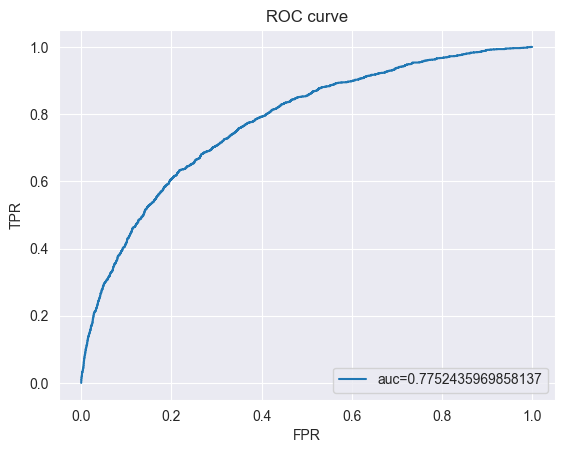

In [9]:
gini_coef = calc_gini_coef(y_true, y_pred_proba)
print('Gini Coefficient: ', gini_coef)

plot_roc_curve(y_true, y_pred_proba)

In [ ]:
y_pred = (y_pred_proba >= 0.5).astype(int)
print(classification_report(y_true, y_pred))

In [ ]:
plot_pr_curve(y_true, y_pred_proba)

In [ ]:
# Feature importance
for imp_type in ('weight', 'gain'):
    fig, ax = plt.subplots(figsize=(10, 6))
    xgb.plot_importance(model, ax=ax, importance_type=imp_type, max_num_features=25)
    plt.title(f'XGBoost Feature Importance (Top 25 by {imp_type})')
    plt.show()